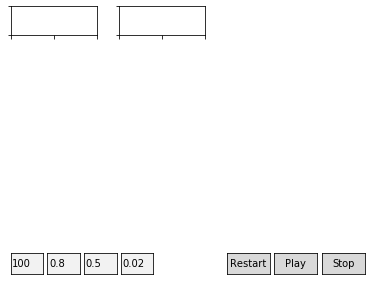

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial.distance import pdist, squareform
from matplotlib.widgets import Button, TextBox

class Animator(animation.FuncAnimation):
    def __init__(self, fig, func, p, frames=None, init_func=None, fargs=None,
                 save_count=None, maxtime=10**5, pos=(0.125, 0.92), **kwargs):
        self.i = 0
        self.min = 0
        self.max = maxtime
        self.runs = True
        self.forwards = True
        self.fig = fig
        self.func = func
        self.setup(pos)
        self.p = p
        animation.FuncAnimation.__init__(self,self.fig, self.func, frames=self.play(), init_func=init, blit=True, fargs=fargs, save_count=save_count, **kwargs)

    def play(self):
        global final
        while self.runs:
            self.i = self.i+self.forwards-(not self.forwards)
            if self.i > self.min and self.i < self.max:
                yield self.i
            else:
                self.stop()
                yield self.i
            if final:
                p.plot()
                self.stop()
                yield self.i

    def start(self, event=None):
        self.runs = True
        self.event_source.start()

    def restart(self, event):
        global axgraph1, axgraph2
        self.runs = True
        self.i = 1
        clearaxes()
        begin()
        self.start()

    def stop(self, event=None):
        self.runs = False
        self.event_source.stop()

    def setup(self, pos):
        axrestart = plt.axes([0.59, 0.05, 0.1, 0.075])
        self.brestart = Button(axrestart, 'Restart')
        self.brestart.on_clicked(self.restart)
        axplay = plt.axes([0.7, 0.05, 0.1, 0.075])
        self.bplay = Button(axplay, 'Play')
        self.bplay.on_clicked(self.start)
        axstop = plt.axes([0.81, 0.05, 0.1, 0.075])
        self.bstop = Button(axstop, 'Stop')
        self.bstop.on_clicked(self.stop)

class Personas:
    def __init__(self,
                 posicion = [],
                 velocidad = [],
                 estado = [],
                 radio = 0.03,
                 cradio = 0.04,
                 limites =[-3.8, 3.8, -2.4, 2.4],
                 tiempo = 0,
                 tcontagio = []):
        self.posicion = posicion
        self.velocidad = velocidad
        self.estado = estado
        self.radio = radio
        self.cradio = cradio
        self.limites = limites
        self.tiempo = tiempo
        self.tcontagio = np.zeros(len(self.estado))
        self.colors = ["dodgerblue", "tomato", "gold", "grey"]

    def esparcir(self):
        collision = False
        dist = squareform(pdist(self.posicion))
        p1, p2 = np.where(dist < 2 * self.radio)
        unique = (p1 < p2)
        p1 = p1[unique]; p2 = p2[unique]
        for i1, i2 in zip(p1, p2):
            #Posición
            self.posicion[i1] += [self.radio * (np.random.uniform() - 0.5), self.radio * (np.random.uniform() - 0.5)]
            self.posicion[i2] += [self.radio * (np.random.uniform() - 0.5), self.radio * (np.random.uniform() - 0.5)]
            collision = True
        return collision

    def step(self, dt):
        global contador, final
        #Tiempo y posición
        self.tiempo += dt
        if self.tiempo.is_integer():
            if online_graphs:
                self.plot()
            #Contadores
            contador = np.vstack((contador, [int(np.count_nonzero(self.estado == 0)),
                                             int(np.count_nonzero(self.estado == 1)),
                                             int(np.count_nonzero(self.estado == 2)),
                                             int(np.count_nonzero(self.estado == 3))]))
            #print(contador[-1])
            if(contador[-1][1] == 0):
                final = True

            self.plot()

        self.tcontagio[self.estado == 1] += dt
        self.posicion += dt * self.velocidad

        #Encontrar colisiones
        dist = squareform(pdist(self.posicion))
        p1, p2 = np.where(dist < 2 * self.radio)
        unique = (p1 < p2)
        p1 = p1[unique]; p2 = p2[unique]
        for i1, i2 in zip(p1, p2):
            if self.estado[i1] != 3 and self.estado[i2] != 3:
                #Posición
                r1 = self.posicion[i1]
                r2 = self.posicion[i2]
                #Velocidad
                v1 = self.velocidad[i1]
                v2 = self.velocidad[i2]
                #Colisión
                r = r1 - r2
                d=((v1-v2)/r).real*r
                if v1.any() > 0.01 and v2.any() > 0.01:
                    self.velocidad[i1] = v1-d
                    self.velocidad[i2] = v2+d
                elif v1.any() > 0.01:
                    self.velocidad[i1] = -v1
                elif v2.any() > 0.01:
                    self.velocidad[i2] = -v2

        #Contagios
        c1, c2 = np.where(dist < 2 * self.cradio)
        unique = (c1 < c2)
        c1 = c1[unique]; c2 = c2[unique]
        for i1, i2 in zip(c1, c2):
            if (self.estado[i1] == 1 and self.estado[i2] == 0) or (self.estado[i1] == 0 and self.estado[i2] == 1):
                self.estado[i1] = self.estado[i2] = 1

        #Bordes
        outbound = [(self.posicion[:, 0] < self.limites[0] + self.radio),
                   (self.posicion[:, 0] > self.limites[1] - self.radio),
                   (self.posicion[:, 1] < self.limites[2] + self.radio),
                   (self.posicion[:, 1] > self.limites[3] - self.radio)]

        self.posicion[outbound[0], 0] = self.limites[0] + self.radio
        self.posicion[outbound[1], 0] = self.limites[1] - self.radio

        self.posicion[outbound[2], 1] = self.limites[2] + self.radio
        self.posicion[outbound[3], 1] = self.limites[3] - self.radio

        self.velocidad[outbound[0] | outbound[1], 0] *= -1
        self.velocidad[outbound[2] | outbound[3], 1] *= -1

        #Recuperación
        for i in range(n_personas):
            if self.estado[i] == 1:
                if self.tcontagio[i] > tiempo_recuperacion[i]:
                    self.estado[i] = 2
                    if np.random.uniform() <= letalidad:
                        self.estado[i] = 3
                        self.velocidad[i] = [0,0]

    def plot(self):
        global contador, axgraph1, axgraph2
        c = [contador[:,0], contador[:,1], contador[:,2], contador[:,3]]

        axgraph1.fill_between(range(len(c[3])), 0, c[3], color=self.colors[3])
        axgraph1.fill_between(range(len(c[2])), c[3], c[3]+c[2], color=self.colors[2])
        axgraph1.fill_between(range(len(c[1])), c[3]+c[2], c[3]+c[2]+c[1], color=self.colors[1])
        axgraph1.fill_between(range(len(c[0])), c[3]+c[2]+c[1], c[3]+c[2]+c[1]+c[0], color=self.colors[0])

        logc = [0 if i == 0 else np.log10(i) for i in c[1]]
        axgraph2.plot(range(len(c[1])), logc, color="dodgerblue")

#Datos importantes
n_personas = 100
moviendose = .8
velocidad = 0.5
dt = 1. / 32
tiempo_recuperacion_medio = 14
variacion_recuperacion = 3
letalidad = 0.02
online_graphs = False
final = False

def begin():
    global p, empezar, n_activo, tiempo_recuperacion, contador
    #Datos
    n_activo = int(n_personas*moviendose)
    tiempo_recuperacion = np.ones(n_personas) * tiempo_recuperacion_medio + (np.random.random(n_personas) - 0.5) * variacion_recuperacion
    contador = np.zeros((1, 4))
    contador[0, 0] = n_personas

    #Posición
    pos_inicial = (np.random.random((n_personas, 2)) - 0.5)
    pos_inicial[:, 0] *= 7.5
    pos_inicial[:, 1] *= 4.6
    empezar = False

    #Velocidad
    direccion = (np.random.random((n_personas, 2)) - 0.5)
    modulo = np.sqrt(direccion[:, 0]**2 + direccion[:, 1]**2)
    vel_inicial = np.zeros((n_personas, 2))
    vel_inicial[0:n_activo, 0] = (direccion[0:n_activo, 0] / modulo[0:n_activo]) * velocidad
    vel_inicial[0:n_activo, 1] = (direccion[0:n_activo, 1] / modulo[0:n_activo]) * velocidad

    #Estado inicial
    est_inicial = np.zeros(n_personas)
    est_inicial[0] = 1

    #Crear mundo
    p = Personas(posicion=pos_inicial, velocidad=vel_inicial, estado=est_inicial)

begin()

#Dibujar figura
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0.15, top=0.85)
ax = fig.add_subplot(111, aspect="equal", autoscale_on=False, xlim=(-4, 4), ylim=(-2.5, 2.5))
fig.patch.set_visible(False)
ax.axis('off')

sanos, = ax.plot([], [], color="dodgerblue", marker="o", linestyle="", markersize=6, zorder=4)
enfermos, = ax.plot([], [], color="tomato", marker="o", linestyle="", markersize=6, zorder=3)
recuperados, = ax.plot([], [], color="gold", marker="o", linestyle="", markersize=6, zorder=2)
muertos, = ax.plot([], [], color="grey", marker="o", linestyle="", markersize=6, zorder=1)
rect = plt.Rectangle((p.limites[0], p.limites[2]), p.limites[1]-p.limites[0], p.limites[3]-p.limites[2], ec="white", lw=2, fc="none")
ax.add_patch(rect)

axtp = plt.axes([0.09, 0.05, 0.075, 0.075])
def submitpers(text):
    global n_personas
    n_personas = int(text)
    if n_personas > 10000:
        n_personas = 10000
    if n_personas < 1:
        n_personas = 1
    text = str(n_personas)
    begin()
textpersonas = TextBox(axtp, "", initial = str(n_personas))
textpersonas.on_submit(submitpers)

axtm = plt.axes([0.175, 0.05, 0.075, 0.075])
def submitmov(text):
    global moviendose
    moviendose = float(text)
    if moviendose > 1:
        moviendose = 1
    if moviendose < 0:
        moviendose = 0
    text = str(moviendose)
    begin()
textmov = TextBox(axtm, "", initial = str(moviendose))
textmov.on_submit(submitmov)

axtv = plt.axes([0.26, 0.05, 0.075, 0.075])
def submitvel(text):
    global velocidad
    velocidad = float(text)
    if velocidad > 5:
        velocidad = 5
    if velocidad < 0:
        velocidad = 0
    text = str(velocidad)
    begin()
textvel = TextBox(axtv, "", initial = str(velocidad))
textvel.on_submit(submitvel)

axtl = plt.axes([0.345, 0.05, 0.075, 0.075])
def submitlet(text):
    global letalidad
    letalidad = float(text)
    if letalidad > 1:
        letalidad = 1
    if letalidad < 0:
        letalidad = 0
    text = str(velocidad)
    begin()
textlet = TextBox(axtl, "", initial = str(letalidad))
textlet.on_submit(submitlet)

plt.text(-3.45, -0.4, "Personas, % en movimiento, velocidad y letalidad", color="white", fontsize="8", horizontalalignment="left")

axgraph1 = plt.axes([0.09, 0.88, 0.2, 0.1])
axgraph2 = plt.axes([0.34, 0.88, 0.2, 0.1])
def clearaxes():
    axgraph1.clear()
    axgraph2.clear()
    axgraph1.set_yticklabels([])
    axgraph1.set_xticklabels([])
    axgraph2.set_yticklabels([])
    axgraph2.set_xticklabels([])
clearaxes()


#Iniciar
def init():
    global p
    sanos.set_data([], [])
    enfermos.set_data([], [])
    recuperados.set_data([], [])
    muertos.set_data([], [])
    return sanos, enfermos, recuperados, muertos,

#Animación
def animate(i):
    global m, dt, ax, fig, empezar
    if empezar:
        p.step(dt)
    else:
        empezar = not p.esparcir()
    ps = p.posicion[p.estado == 0]
    sanos.set_data(ps[:, 0], ps[:, 1])
    pe = p.posicion[p.estado == 1]
    enfermos.set_data(pe[:, 0], pe[:, 1])
    pr = p.posicion[p.estado == 2]
    recuperados.set_data(pr[:, 0], pr[:, 1])
    pm = p.posicion[p.estado == 3]
    muertos.set_data(pm[:, 0], pm[:, 1])
    return sanos, enfermos, recuperados, muertos,

#Exportar
ani = Animator(fig, animate, p, maxtime=10**5, interval=10)
plt.show()

In [6]:
from IPython.display import HTML
HTML(ani.to_html5_video())

In [8]:
HTML(ani.to_jshtml())